In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats as sp
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
# define relevant age group and location ids
ages = list(range(7,16))
locs = [161, 165, 182, 214] # bangladesh, pakistan, malawi, nigeria

# Notebook overview

1. Get population sizes
2. Baseline anemia prevalence
3. Salt anemia prevalence
4. ANC anemia prevalence
5. IV iron (without salt) anemia prevalence
6. Iv iron with salt anemia prevalence 
7. Compile anemia dataframes
8. Calculate baseline maternal disorders burden attributable to iron deficiency
9. Calculate counterfactual maternal disorders burden attributable to iron deficiency based on counterfactual population hemoglobin
10. Overall dalys averted and plots

# 1. Get population sizes

No outstanding tasks :) 

In [3]:
# get population
pop = get_population(location_id=locs,
                    age_group_id=ages,
                    sex_id=2,
                    year_id=2019,
                    gbd_round_id=6,
                    decomp_step='step4')
pop = pop.set_index(['location_id','age_group_id']).drop(columns=['year_id','sex_id','run_id'])
pop.head()

population
location_id age_group_id              
161         7             7.695495e+06
            8             7.921423e+06
            9             7.756269e+06
            10            7.297086e+06
            11            6.586882e+06

In [4]:
# functions to turn mean/upper/lower estimates into 1,000 draws assuming a normal distribution

def generate_age_and_location_specific_draws(data):
    data_draws = pd.DataFrame()
    for i in list(range(0,len(data))):
        temp = pd.DataFrame()
        temp['location_id'] = [data['location_id'][i]]
        temp['age_group_id'] = [data['age_group_id'][i]]
        for n in list(range(0,1_000)):
            temp[f'draw_{n}'] = [sp.norm.rvs(data['mean_value'][i], 
                           (data['upper_value'][i] - data['lower_value'][i])/2/1.96)]
        data_draws = data_draws.append(temp)
    data_draws = data_draws.set_index(['location_id','age_group_id'])
    return data_draws

def generate_location_specific_draws(data):
    data_draws = pd.DataFrame()
    for i in list(range(0,len(data))):
        temp = pd.DataFrame()
        temp['location_id'] = [data['location_id'][i]]
        for n in list(range(0,1_000)):
            temp[f'draw_{n}'] = [sp.norm.rvs(data['mean_value'][i], 
                           (data['upper_value'][i] - data['lower_value'][i])/2/1.96)]
        data_draws = data_draws.append(temp)
    data_draws = data_draws.set_index(['location_id'])
    return data_draws


# even though these are universal, this function generates identical values for each location id
# so that the resulting dataframe can be multiplied with others of the same index
# this way we assume identical effect sizes between model locations
def generate_universal_draws(mean, lower, upper):
    data_draws = pd.DataFrame()
    loc_list = [161, 165, 182, 214]
    temp = pd.DataFrame()
    for n in list(range(0,1_000)):
        temp[f'draw_{n}'] = [sp.norm.rvs(mean, (upper - lower)/2/1.96)]
    data_draws = data_draws.append(temp)
    data_draws = data_draws.append(temp)
    data_draws = data_draws.append(temp)
    data_draws = data_draws.append(temp)
    data_draws['location_id'] = loc_list
    data_draws = data_draws.set_index('location_id')
    return data_draws        

In [5]:
# get age-specific fertility rate
asfr = get_covariate_estimates(13, 
                               location_id=locs,
                               age_group_id=ages,
                               sex_id=2,
                               year_id=2019,
                               gbd_round_id=6,
                               decomp_step='step4')

# generate draws from ASFR upper and lower limits
asfr_draws = generate_age_and_location_specific_draws(asfr)

# get still birth to live birth ratio (not age-specific)
still = get_covariate_estimates(2267, 
                                location_id=locs,
                                year_id=2019,
                                gbd_round_id=6,
                                decomp_step='step4')
# generate draws
still_draws = generate_location_specific_draws(still)

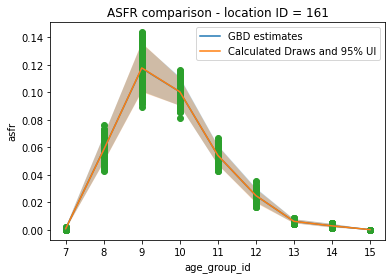

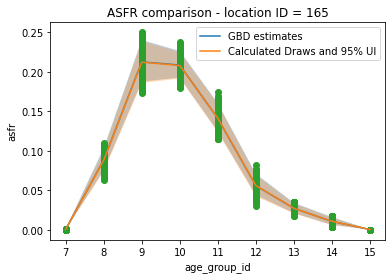

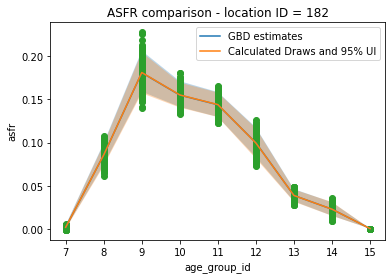

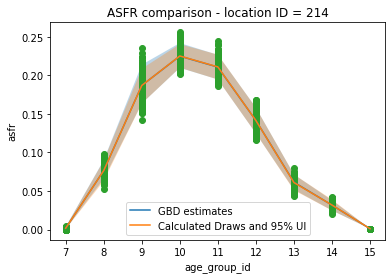

In [6]:
# confirm that ASFR draw generation was successful

asfr_test = pd.DataFrame(asfr_draws.stack()).reset_index().rename(columns={'level_2':'draw',0:'value'})
asfr_test_avg = asfr_test.groupby(['location_id','age_group_id']).describe(percentiles=[0.025,0.975]).reset_index()

def verify_generated_draws(locs):
    for i in list(range(len(locs))):
        location = locs[i]
        asfr_plot = asfr.loc[asfr.location_id == location]
        asfr_draws_plot = asfr_test.loc[asfr_test.location_id == location]
        asfr_draws_plot_avg = asfr_test_avg.loc[asfr_test_avg.location_id == location]
        fig, ax = plt.subplots()
        plt.plot(asfr_plot['age_group_id'], asfr_plot['mean_value'])
        plt.fill_between(asfr_plot['age_group_id'], asfr_plot['upper_value'], asfr_plot['lower_value'], alpha=0.3)
        plt.plot(asfr_draws_plot_avg['age_group_id'], asfr_draws_plot_avg['value','mean'])
        plt.fill_between(asfr_draws_plot_avg['age_group_id'], asfr_draws_plot_avg['value','97.5%'], asfr_draws_plot_avg['value','2.5%'], alpha=0.3)
        plt.scatter(asfr_draws_plot['age_group_id'],asfr_draws_plot['value'])
        
        plt.xlabel('age_group_id')
        plt.ylabel('asfr')
        plt.legend(['GBD estimates','Calculated Draws and 95% UI'])
        plt.title(f'ASFR comparison - location ID = {location}')

verify_generated_draws(locs)
# looks good!

In [7]:
# calculate pregnancy rate

# GBD pregnancy (and lactation) prevalence = (ASFR + stillbirths) * 46/52

    # assumes 40 weeks pregnancy and 6 weeks lactation

# but still-birth covariate is measured in still births per live birth,
# so...

    # age-spec-preg-and-lactation-prev = (ASFR + (stillbirths * ASFR)) * 46/52
    
p_preg = (asfr_draws + (still_draws * asfr_draws)) * 40/52
p_lac = (asfr_draws + (still_draws * asfr_draws)) * 6/52
p_preg_and_lac = p_preg + p_lac
p_preg_and_lac.head()

draw_0    draw_1    draw_2    draw_3    draw_4  \
location_id age_group_id                                                     
161         7             0.000389  0.000537  0.000887  0.000613  0.000498   
            8             0.047084  0.049345  0.047059  0.060779  0.052956   
            9             0.097369  0.112895  0.117722  0.117267  0.094642   
            10            0.087439  0.097916  0.095911  0.086500  0.085125   
            11            0.051027  0.049423  0.047069  0.053392  0.049236   

                            draw_5    draw_6    draw_7    draw_8    draw_9  \
location_id age_group_id                                                     
161         7             0.000820  0.000788  0.000747  0.000635  0.000379   
            8             0.053223  0.049815  0.055693  0.049877  0.052990   
            9             0.103535  0.106012  0.106111  0.112021  0.112234   
            10            0.084067  0.085759  0.095327  0.092488  0.085584   
            11            0.053450  0.045719  0.045279  0.047826  0.049629   

                          ...  draw_990  draw_991  draw_992  draw_993  \
location_id age_group_id  ...                                           
161         7             ...  0.000665  0.001170  0.000502  0.000937   
            8             ...  0.051401  0.055819  0.055450  0.055173   
            9             ...  0.106084  0.106184  0.105842  0.110889   
            10            ...  0.092547  0.097181  0.091045  0.089849   
            11            ...  0.047718  0.045521  0.050170  0.046957   

                          draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id                                                     
161         7             0.000615  0.000841  0.000326  0.001022  0.000255   
            8             0.055509  0.059003  0.049907  0.046488  0.056384   
            9             0.104004  0.090697  0.121408  0.107321  0.104170   
            10            0.090960  0.094550  0.081936  0.092505  0.095249   
            11            0.055060  0.050811  0.050953  0.046886  0.050621   

                          draw_999  
location_id age_group_id            
161         7             0.000662  
            8             0.046035  
            9             0.101652  
            10            0.086384  
            11            0.048213  

[5 rows x 1000 columns]

In [8]:
# get proportion of women who attend ANC (single visit)
anc = get_covariate_estimates(covariate_id=7,
                             location_id=locs,
                             year_id=2019,
                             gbd_round_id=6,
                             decomp_step='step4')
    # generate draws
anc_draws = generate_location_specific_draws(anc)

# making the assumption that ANC4 == PNC coverage
pnc = get_covariate_estimates(covariate_id=8,
                             location_id=locs,
                             year_id=2019,
                             gbd_round_id=6,
                             decomp_step='step4')
    # generate draws
pnc_draws = generate_location_specific_draws(pnc)

In [9]:
# fraction of women of reproductive age eligible for second intervention tier
    # pregnant women who attend anc and lactating women who attend pnc
tier_2_frac = p_preg * anc_draws + p_lac * pnc_draws
tier_2_frac.head()

draw_0    draw_1    draw_2    draw_3    draw_4  \
location_id age_group_id                                                     
161         7             0.000318  0.000430  0.000718  0.000486  0.000391   
            8             0.038444  0.039568  0.038122  0.048237  0.041519   
            9             0.079501  0.090526  0.095365  0.093069  0.074203   
            10            0.071393  0.078515  0.077696  0.068650  0.066741   
            11            0.041663  0.039631  0.038130  0.042375  0.038603   

                            draw_5    draw_6    draw_7    draw_8    draw_9  \
location_id age_group_id                                                     
161         7             0.000640  0.000650  0.000622  0.000526  0.000301   
            8             0.041571  0.041083  0.046361  0.041328  0.042069   
            9             0.080868  0.087430  0.088331  0.092822  0.089104   
            10            0.065662  0.070727  0.079355  0.076636  0.067946   
            11            0.041748  0.037705  0.037692  0.039629  0.039401   

                          ...  draw_990  draw_991  draw_992  draw_993  \
location_id age_group_id  ...                                           
161         7             ...  0.000516  0.000896  0.000406  0.000798   
            8             ...  0.039892  0.042713  0.044816  0.046987   
            9             ...  0.082332  0.081252  0.085545  0.094437   
            10            ...  0.071826  0.074363  0.073586  0.076518   
            11            ...  0.037034  0.034833  0.040549  0.039990   

                          draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id                                                     
161         7             0.000504  0.000673  0.000259  0.000771  0.000207   
            8             0.045423  0.047199  0.039729  0.035080  0.045860   
            9             0.085106  0.072554  0.096650  0.080985  0.084727   
            10            0.074432  0.075636  0.065227  0.069804  0.077471   
            11            0.045056  0.040647  0.040563  0.035380  0.041172   

                          draw_999  
location_id age_group_id            
161         7             0.000514  
            8             0.035793  
            9             0.079036  
            10            0.067164  
            11            0.037486  

[5 rows x 1000 columns]

In [10]:
# generate draws for population size data so that it can be multiplied
# with the other dataframes
# NOTE: there is no uncertainty in GBD 2019 population size estimates, so 
# the values are identical for each draw
pop_draws = pd.DataFrame(index=tier_2_frac.index)
for i in list(range(0,1000)):
    pop_draws[f'draw_{i}'] = pop['population'].values

# 2. Baseline anemia

No outstanding tasks :) 

In [11]:
# mean hemoglobin concentration
mean = get_draws('modelable_entity_id',
                10487,
                source='epi',
                location_id=locs,
                age_group_id=ages,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4',
                status='best')
# hemoglobin distribution standard deviation
sd = get_draws('modelable_entity_id',
                10488,
                source='epi',
                location_id=locs,
                age_group_id=ages,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4',
                status='best')

In [12]:
mean.to_excel("mean.xlsx")
sd.to_excel("sd.xlsx")
asfr.to_excel("asfr.xlsx")
still.to_excel("sb.xlsx")

*** NOW RUN R CODE LOCALLY ***

file = hemoglobin_r_code.R

In [13]:
def process_r_output(filepath,intervention):
        # read in data
    data = pd.read_csv(filepath)
        # there is a weird incompatibility from the excel file, so remove this data
    draws = [c for c in np.unique(data['draw']) if 'draw' in c]
    data = data.loc[data['draw'].isin(draws)]
        # keep relevant data
    data = data.set_index(['location_id','age_group_id','draw'])
    data = data[['mild','moderate','severe','mild_preg','moderate_preg','severe_preg']]
        # reformat data shape (move severity and pregnancy status to index rather than multiple columns)
    data = pd.DataFrame(data.stack()).reset_index().rename(columns={0:'prevalence','level_3':'measure'})
    data['severity'] = np.where(data['measure'].str.contains('mild'), 'mild',
                           np.where(data['measure'].str.contains('moderate'), 'moderate', 'severe'))
    data['pregnant'] = np.where(data['measure'].str.contains('preg'), 1, 0)
    data['dw'] = np.where(data['severity'] == 'mild', 0.004,
                         np.where(data['severity'] == 'moderate', 0.052, 0.149))
        # calculate ylds
    data['ylds'] = data['prevalence'] * data['dw']
    data = data.drop(columns=['measure','dw'])
    data['intervention'] = intervention
    return data

In [14]:
anemia_prev = process_r_output('anemia_prev.csv','baseline')
anemia_prev.head()

,location_id,age_group_id,draw,prevalence,severity,pregnant,ylds,intervention
0,161,7,draw_0,0.046288,mild,0,0.000185,baseline
1,161,7,draw_0,0.056471,moderate,0,0.002936,baseline
2,161,7,draw_0,0.002308,severe,0,0.000344,baseline
3,161,7,draw_0,0.106447,mild,1,0.000426,baseline
4,161,7,draw_0,0.188317,moderate,1,0.009792,baseline


In [15]:
# this function is used to identify the proportion of pregnant women who have hemoglobin levels
# below 10 g/dL -- used for the IV target
def get_iv_target_from_r_output(filepath):
    data = pd.read_csv(filepath)
    draws = [c for c in np.unique(data['draw']) if 'draw' in c]
    data = data.loc[data['draw'].isin(draws)]
    data = data.set_index(['location_id','age_group_id','draw'])
    data = data[['iv_target_preg']]
        # iv target prevalence from r code is specific to all pregnant and lactating women
        # we need to rescale to pregnant (40/46) women in their 2nd and 3rd trimesters (2/3)
    data['iv_target_preg'] = data['iv_target_preg'] * (40/46) * (2/3)
    data = pd.DataFrame(data.stack()).reset_index().rename(columns={0:'prevalence','level_3':'measure'})
    data = pd.pivot_table(data, index=['location_id','age_group_id'], columns='draw', values='prevalence')
    return data

In [16]:
baseline_iv_target = get_iv_target_from_r_output('anemia_prev.csv')
baseline_iv_target.head()

draw                        draw_0    draw_1   draw_10  draw_100  draw_101  \
location_id age_group_id                                                     
161         7             0.039431  0.026042  0.057739  0.038598  0.015752   
            8             0.134078  0.051292  0.064851  0.074755  0.064902   
            9             0.128435  0.128629  0.099468  0.103380  0.115059   
            10            0.074049  0.078451  0.105967  0.082241  0.071735   
            11            0.084520  0.127699  0.083408  0.049333  0.060752   

draw                      draw_102  draw_103  draw_104  draw_105  draw_106  \
location_id age_group_id                                                     
161         7             0.016614  0.030878  0.054527  0.043400  0.012135   
            8             0.077261  0.065338  0.076584  0.065601  0.044731   
            9             0.100073  0.079866  0.121108  0.105121  0.120207   
            10            0.109528  0.103694  0.071244  0.061583  0.116540   
            11            0.054185  0.126173  0.101291  0.097762  0.103645   

draw                      ...  draw_990  draw_991  draw_992  draw_993  \
location_id age_group_id  ...                                           
161         7             ...  0.010278  0.040578  0.036958  0.041364   
            8             ...  0.036374  0.064278  0.054648  0.038030   
            9             ...  0.058959  0.126095  0.117891  0.093426   
            10            ...  0.096212  0.127312  0.067565  0.069813   
            11            ...  0.193032  0.067179  0.169958  0.080012   

draw                      draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id                                                     
161         7             0.029350  0.023591  0.008934  0.026811  0.042380   
            8             0.104488  0.071683  0.097047  0.084302  0.081333   
            9             0.076566  0.075069  0.077888  0.117444  0.109311   
            10            0.113568  0.112478  0.085805  0.077331  0.118900   
            11            0.120371  0.094529  0.052034  0.075280  0.098390   

draw                      draw_999  
location_id age_group_id            
161         7             0.025045  
            8             0.050378  
            9             0.069239  
            10            0.075319  
            11            0.130028  

[5 rows x 1000 columns]

In [17]:
# fraction of population eligible for the 3rd intervention tier
    # assuming that ANC visits are equally distributed throughout duration of pregnancy

tier_3_no_salt_frac = p_preg * anc_draws * (2/3) * baseline_iv_target
tier_3_no_salt_frac.head()

draw_0    draw_1   draw_10  draw_100  draw_101  \
location_id age_group_id                                                     
161         7             0.000008  0.000007  0.000024  0.000019  0.000004   
            8             0.003208  0.001260  0.001703  0.002034  0.001853   
            9             0.006354  0.007227  0.005213  0.005622  0.006199   
            10            0.003290  0.003823  0.005050  0.003491  0.003512   
            11            0.002191  0.003141  0.002291  0.001109  0.001567   

                          draw_102  draw_103  draw_104  draw_105  draw_106  \
location_id age_group_id                                                     
161         7             0.000007 -0.000002  0.000023  0.000012  0.000003   
            8             0.001851  0.001959  0.001764  0.001566  0.001062   
            9             0.005421  0.004028  0.005591  0.005687  0.005665   
            10            0.005105  0.004530  0.003464  0.002581  0.004634   
            11            0.001205  0.003085  0.002301  0.002227  0.002654   

                          ...  draw_990  draw_991  draw_992  draw_993  \
location_id age_group_id  ...                                           
161         7             ...  0.000003  0.000023  0.000009  0.000021   
            8             ...  0.000904  0.001712  0.001526  0.001111   
            9             ...  0.003025  0.006390  0.006284  0.005485   
            10            ...  0.004306  0.005904  0.003098  0.003321   
            11            ...  0.004455  0.001459  0.004295  0.001989   

                          draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id                                                     
161         7             0.000009  0.000010  0.000001  0.000013  0.000005   
            8             0.002974  0.002103  0.002387  0.001807  0.002312   
            9             0.004084  0.003385  0.004660  0.005812  0.005740   
            10            0.005297  0.005287  0.003464  0.003298  0.005709   
            11            0.003399  0.002388  0.001306  0.001627  0.002511   

                          draw_999  
location_id age_group_id            
161         7             0.000008  
            8             0.001119  
            9             0.003396  
            10            0.003139  
            11            0.003025  

[5 rows x 1000 columns]

# 3. Salt anemia

In [18]:
# generate draws for the salt effect size

double_fortified_salt_risk_difference = generate_universal_draws(3.3, 1.8, 4.8)

# check to make sure that mean and limits are as expected
salt_test = double_fortified_salt_risk_difference.reset_index().loc[double_fortified_salt_risk_difference.reset_index().location_id==161].drop(columns='location_id')
salt_test = pd.DataFrame(salt_test.stack()).describe(percentiles=[0.025,0.975])
salt_test.transpose()

# this looks good!

,count,mean,std,min,2.5%,50%,97.5%,max
0,1000.0,3.282334,0.754788,0.78663,1.810997,3.290425,4.755855,5.742384


In [19]:
# reformat baseline mean population hemoglobin dataframe
baseline_hb = mean.set_index(['location_id','age_group_id'])
baseline_hb = baseline_hb.drop(columns=[c for c in baseline_hb.columns if 'draw' not in c])

# create dataframe for counterfactual mean hemoglobin in salt intervention scenario
# ASSUMES NO EXISTING COVERAGE OF SALT FORTIFICATION (checks out) AND UNIVERSAL COVERAGE

salt_hb = pd.DataFrame(index=baseline_hb.index)
for i in list(range(0,1000)):
    salt_hb[f'draw_{i}'] = baseline_hb[f'draw_{i}'] + double_fortified_salt_risk_difference[f'draw_{i}']
salt_hb.head()

draw_0      draw_1      draw_2      draw_3  \
location_id age_group_id                                                   
161         7             134.516479  134.230428  135.398644  134.425026   
            8             121.862583  130.445159  130.506059  131.720318   
            9             122.385226  123.968462  128.775294  132.180784   
            10            128.223538  129.232698  128.487148  124.326575   
            11            128.062331  125.370946  125.266609  125.222313   

                              draw_4      draw_5      draw_6      draw_7  \
location_id age_group_id                                                   
161         7             132.731478  134.395963  133.831983  135.988044   
            8             130.718342  126.579430  132.867940  131.403565   
            9             126.421726  124.569376  129.320484  127.018304   
            10            125.071608  129.294398  121.625516  124.860128   
            11            129.328804  125.549346  125.360797  128.177361   

                              draw_8      draw_9  ...    draw_990    draw_991  \
location_id age_group_id                          ...                           
161         7             134.680077  127.689266  ...  135.952436  130.640944   
            8             133.060857  130.637616  ...  132.306468  128.901183   
            9             127.459893  127.908284  ...  130.514506  124.776585   
            10            125.927834  127.570258  ...  124.489098  122.866995   
            11            126.239831  128.878249  ...  118.159341  128.877603   

                            draw_992    draw_993    draw_994    draw_995  \
location_id age_group_id                                                   
161         7             135.642897  130.350738  134.707214  132.791512   
            8             132.370163  132.541395  124.349362  130.139394   
            9             124.793169  123.024980  125.822922  128.343437   
            10            129.146057  126.261152  125.673425  123.810793   
            11            119.908428  126.949690  125.310912  126.750980   

                            draw_996    draw_997    draw_998    draw_999  
location_id age_group_id                                                  
161         7             135.581528  135.064326  132.033647  133.296333  
            8             127.259193  126.806992  126.309214  132.643673  
            9             127.482701  124.239997  123.219576  129.998689  
            10            126.685718  128.826599  122.765776  126.860175  
            11            129.842548  129.498835  125.377173  124.865562  

[5 rows x 1000 columns]

In [20]:
# reformat dataframe so that it is compatibel with GBD R code
def prep_for_r_code(data):
    data_prepped = data.reset_index()
    for c in [c for c in mean.columns if c not in data_prepped.columns]:
        data_prepped[f'{c}'] = mean[f'{c}']
    return data_prepped

salt_hb_prepped = prep_for_r_code(salt_hb)
# export to be run through R code
salt_hb_prepped.to_excel("mean_salt.xlsx")

*** NOW RUN SALT.R ***

In [21]:
# import results from R script
anemia_prev_salt = process_r_output('anemia_prev_salt.csv','salt')
anemia_prev_salt.head()

,location_id,age_group_id,draw,prevalence,severity,pregnant,ylds,intervention
0,161,7,draw_0,0.034636,mild,0,0.000139,salt
1,161,7,draw_0,0.040620,moderate,0,0.002112,salt
2,161,7,draw_0,0.001775,severe,0,0.000264,salt
3,161,7,draw_0,0.091634,mild,1,0.000367,salt
4,161,7,draw_0,0.147744,moderate,1,0.007683,salt


In [22]:
# calculate new proportion of pregnant women with hemoglobin less than 10
# assuming universal coverage of double fortified salt
salt_iv_target = get_iv_target_from_r_output('anemia_prev_salt.csv')
salt_iv_target.head()

draw                        draw_0    draw_1   draw_10  draw_100  draw_101  \
location_id age_group_id                                                     
161         7             0.029500  0.016011  0.036614  0.023544  0.010293   
            8             0.106870  0.033055  0.038579  0.051944  0.045343   
            9             0.102028  0.095285  0.070029  0.076439  0.081669   
            10            0.056510  0.055243  0.066965  0.054150  0.050242   
            11            0.066231  0.097571  0.056197  0.032337  0.044160   

draw                      draw_102  draw_103  draw_104  draw_105  draw_106  \
location_id age_group_id                                                     
161         7             0.010270  0.019776  0.037293  0.029755  0.007237   
            8             0.052631  0.043394  0.052478  0.047714  0.028509   
            9             0.077265  0.055180  0.091933  0.079144  0.082759   
            10            0.081619  0.074844  0.048715  0.042656  0.079643   
            11            0.036111  0.099220  0.076278  0.073714  0.076081   

draw                      ...  draw_990  draw_991  draw_992  draw_993  \
location_id age_group_id  ...                                           
161         7             ...  0.004807  0.023114  0.025785  0.031126   
            8             ...  0.018957  0.039902  0.038805  0.029128   
            9             ...  0.033776  0.091352  0.089052  0.072579   
            10            ...  0.055100  0.087677  0.047375  0.053877   
            11            ...  0.137200  0.042294  0.132042  0.064062   

draw                      draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id                                                     
161         7             0.020926  0.016065  0.005264  0.017234  0.027958   
            8             0.078999  0.055802  0.072694  0.058794  0.055918   
            9             0.054817  0.057497  0.054899  0.086568  0.077012   
            10            0.090545  0.088259  0.061198  0.054951  0.085660   
            11            0.096946  0.074468  0.034703  0.053803  0.070527   

draw                      draw_999  
location_id age_group_id            
161         7             0.015778  
            8             0.035389  
            9             0.049748  
            10            0.051572  
            11            0.101942  

[5 rows x 1000 columns]

# 4. ANC anemia

BEP for underweight mothers

MMN for normal weight mothers

In [23]:
# get proportion underweight (for BEP targeting)
underweight = get_covariate_estimates(covariate_id=1253,
                                    location_id=locs,
                                    age_group_id=ages,
                                    sex_id=2,
                                    year_id=2019,
                                    gbd_round_id=6,
                                    decomp_step='step4')
underweight_draws = generate_age_and_location_specific_draws(underweight)
underweight_draws.head()

draw_0    draw_1    draw_2    draw_3    draw_4  \
location_id age_group_id                                                     
161         7             0.504078  0.504078  0.504078  0.504078  0.504078   
            8             0.346354  0.346354  0.346354  0.346354  0.346354   
            9             0.189597  0.189597  0.189597  0.189597  0.189597   
            10            0.158055  0.158055  0.158055  0.158055  0.158055   
            11            0.055301  0.055301  0.055301  0.055301  0.055301   

                            draw_5    draw_6    draw_7    draw_8    draw_9  \
location_id age_group_id                                                     
161         7             0.504078  0.504078  0.504078  0.504078  0.504078   
            8             0.346354  0.346354  0.346354  0.346354  0.346354   
            9             0.189597  0.189597  0.189597  0.189597  0.189597   
            10            0.158055  0.158055  0.158055  0.158055  0.158055   
            11            0.055301  0.055301  0.055301  0.055301  0.055301   

                          ...  draw_990  draw_991  draw_992  draw_993  \
location_id age_group_id  ...                                           
161         7             ...  0.504078  0.504078  0.504078  0.504078   
            8             ...  0.346354  0.346354  0.346354  0.346354   
            9             ...  0.189597  0.189597  0.189597  0.189597   
            10            ...  0.158055  0.158055  0.158055  0.158055   
            11            ...  0.055301  0.055301  0.055301  0.055301   

                          draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id                                                     
161         7             0.504078  0.504078  0.504078  0.504078  0.504078   
            8             0.346354  0.346354  0.346354  0.346354  0.346354   
            9             0.189597  0.189597  0.189597  0.189597  0.189597   
            10            0.158055  0.158055  0.158055  0.158055  0.158055   
            11            0.055301  0.055301  0.055301  0.055301  0.055301   

                          draw_999  
location_id age_group_id            
161         7             0.504078  
            8             0.346354  
            9             0.189597  
            10            0.158055  
            11            0.055301  

[5 rows x 1000 columns]

In [24]:
# generate draws for uncertainty

mmn_risk_difference = generate_universal_draws(7.8,4.08,11.52)
bep_risk_difference = generate_universal_draws(3.7,1.9,5.6)

In [25]:
# check uncertainty distribution

mmn_test = mmn_risk_difference.reset_index().loc[mmn_risk_difference.reset_index().location_id==161].drop(columns='location_id')
mmn_test = pd.DataFrame(mmn_test.stack()).describe(percentiles=[0.025,0.975])
mmn_test.transpose()

# looks good

,count,mean,std,min,2.5%,50%,97.5%,max
0,1000.0,7.85782,1.928303,0.95304,4.281739,7.884124,11.585184,14.320341


In [26]:
# check uncertainty distribution
bep_test = bep_risk_difference.reset_index().loc[bep_risk_difference.reset_index().location_id==161].drop(columns='location_id')
bep_test = pd.DataFrame(bep_test.stack()).describe(percentiles=[0.025,0.975])
bep_test.transpose()
# looks good

,count,mean,std,min,2.5%,50%,97.5%,max
0,1000.0,3.67521,0.944839,0.525831,1.783964,3.640203,5.462301,6.566749


In [27]:
# calculate weighted effect of ANC (bep/mmn) intervention SPECIFIC TO THE PREGNANT POPULATION
# this effect will be added to the hemoglobin conc. of pregnant women (in R code) after the salt
# effect size has been applied to the general population, including pregnant women

# assuming additive effects
additive_weighted_anc_effect_size = (anc_draws * (mmn_risk_difference * (1-underweight_draws)
                            + bep_risk_difference * underweight_draws))

# assuming maximum effects
    # this means that salt effect will need to be subtracted out for those who are getting additional coverage
maximum_weighted_anc_effect_size = (anc_draws * (mmn_risk_difference * (1-underweight_draws)
                            + bep_risk_difference * underweight_draws
                            - double_fortified_salt_risk_difference))

# take average of additive and maximum effect
weighted_anc_effect_size = ((additive_weighted_anc_effect_size + maximum_weighted_anc_effect_size) 
                            / 2)

def prep_for_r_code(data):
    data_prepped = data.reset_index()
    for c in [c for c in mean.columns if c not in data_prepped.columns]:
        data_prepped[f'{c}'] = mean[f'{c}']
    return data_prepped

# export for r code
weighted_anc_effect_size_prepped = prep_for_r_code(weighted_anc_effect_size)
weighted_anc_effect_size_prepped.to_excel('weighted_anc_effect_size.xlsx')

In [28]:
# now calculate population hemoglobin in tier 2 intervention scenario in the overall population
# need to multiple by the prevalence of pregnant and lactating women
# this will be used for the maternal disorders counterfactual burden
anc_hb = salt_hb + weighted_anc_effect_size * p_preg_and_lac
anc_hb.head()

draw_0      draw_1      draw_2      draw_3  \
location_id age_group_id                                                   
161         7             134.518026  134.232365  135.401789  134.426043   
            8             122.078205  130.662551  130.693898  131.854927   
            9             122.889670  124.554966  129.297326  132.505122   
            10            128.687115  129.756941  128.921007  124.575407   
            11            128.352973  125.661140  125.493195  125.395193   

                              draw_4      draw_5      draw_6      draw_7  \
location_id age_group_id                                                   
161         7             132.734222  134.398931  133.836055  135.990491   
            8             131.073904  126.822112  133.197609  131.609022   
            9             127.170646  125.138060  130.175104  127.453256   
            10            125.765751  129.771929  122.341778  125.258741   
            11            129.768990  125.885647  125.785906  128.378865   

                              draw_8      draw_9  ...    draw_990    draw_991  \
location_id age_group_id                          ...                           
161         7             134.682417  127.690931  ...  135.955463  130.644311   
            8             133.261176  130.909823  ...  132.583481  129.076544   
            9             127.946411  128.567961  ...  131.174767  125.138183   
            10            126.335599  128.086047  ...  125.080651  123.203093   
            11            126.460931  129.201449  ...  118.490459  129.042907   

                            draw_992    draw_993    draw_994    draw_995  \
location_id age_group_id                                                   
161         7             135.644809  130.354960  134.708826  132.794886   
            8             132.578916  132.836672  124.516172  130.396415   
            9             125.187379  123.711531  126.175212  128.769788   
            10            129.484418  126.832615  125.988526  124.261815   
            11            120.093559  127.274187  125.515446  127.004842   

                            draw_996    draw_997    draw_998    draw_999  
location_id age_group_id                                                  
161         7             135.582374  135.068032  132.034517  133.298623  
            8             127.400804  127.003672  126.533183  132.825928  
            9             127.855809  124.758698  123.691158  130.451429  
            10            126.941408  129.284905  123.207606  127.253513  
            11            130.009423  129.749637  125.630395  125.100733  

[5 rows x 1000 columns]

In [29]:
# now run anc.R

In [30]:
# get anemia prev
anemia_prev_anc = process_r_output('anemia_prev_anc.csv','anc')
anemia_prev_anc.head()

,location_id,age_group_id,draw,prevalence,severity,pregnant,ylds,intervention
0,161,7,draw_0,0.034624,mild,0,0.000138,anc
1,161,7,draw_0,0.040592,moderate,0,0.002111,anc
2,161,7,draw_0,0.001774,severe,0,0.000264,anc
3,161,7,draw_0,0.073146,mild,1,0.000293,anc
4,161,7,draw_0,0.106145,moderate,1,0.005520,anc


# 5. IV iron - without salt

In [31]:
# generate draws assuming normal distribution and check
iv_iron_risk_difference = generate_universal_draws(10,7,15)

iv_iron_test = iv_iron_risk_difference.reset_index().loc[iv_iron_risk_difference.reset_index().location_id==161].drop(columns='location_id')
iv_iron_test = pd.DataFrame(iv_iron_test.stack()).describe(percentiles=[0.025,0.975])
iv_iron_test.transpose()
# looks off

,count,mean,std,min,2.5%,50%,97.5%,max
0,1000.0,9.98318,2.033742,1.619098,5.886289,10.013108,13.906968,16.990176


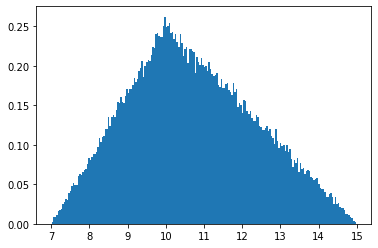

In [32]:
# now try a trianle distribution

h = plt.hist(np.random.triangular(7, 10, 15, 100000), bins=200,
             density=True)
plt.show()

In [33]:
triangle = np.random.triangular(7, 10, 15, 10)
tri_min = triangle.min()
tri_lower = np.quantile(triangle, 0.025)
tri_mean = triangle.mean()
tri_upper = np.quantile(triangle, 0.975)
tri_max = triangle.max()

print(tri_min, tri_lower, tri_mean, tri_upper, tri_max)
# too narrow!

9.195235268255217 9.289633998915376 10.798206248832713 12.766690172904624 12.91360625991528


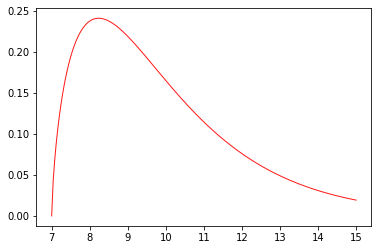

In [34]:
# now try a gamma distribution (code adapted from Nathaniel's code used for price of BEP)
import scipy

loc = 7
dist_mean = 10 - loc
a = 1.7
scale = dist_mean/a
fig, ax = plt.subplots(1,1)
x = np.linspace(loc, loc+(15-7), 200)
ax.plot(x, scipy.stats.gamma.pdf(x, a, loc, scale), 'r-', lw=1, alpha=0.9, label='beta pdf')
plt.show()

In [35]:
gam_test = scipy.stats.gamma.rvs(a, loc, scale, 1000)

gam_min = gam_test.min()
gam_lower = np.quantile(gam_test, 0.025)
gam_mean = gam_test.mean()
gam_upper = np.quantile(gam_test, 0.975)
gam_max = gam_test.max()

print(gam_min, gam_lower, gam_mean, gam_upper, gam_max)

# better! use this distribution for the iv effect size

7.01899875601824 7.290814805046246 10.064986027215815 15.61673082963892 24.09449540659765


In [36]:
iv_iron_risk_difference = pd.DataFrame()
temp = pd.DataFrame()
for i in list(range(0,1000)):
    temp[f'draw_{i}'] = scipy.stats.gamma.rvs(a, loc, scale, 1)
iv_iron_risk_difference = temp.append(temp)
iv_iron_risk_difference = iv_iron_risk_difference.append(temp)
iv_iron_risk_difference = iv_iron_risk_difference.append(temp)
iv_iron_risk_difference['location_id'] = locs
iv_iron_risk_difference = iv_iron_risk_difference.set_index(['location_id']).sort_index()
iv_iron_risk_difference.head()

,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,draw_8,draw_9,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
161,11.277504,9.472557,11.605587,10.902087,9.734892,12.042949,16.245848,9.648099,8.528962,11.260606,...,9.083601,7.308115,9.644249,7.92942,7.663866,10.707261,7.969002,9.829228,9.653088,9.292773
165,11.277504,9.472557,11.605587,10.902087,9.734892,12.042949,16.245848,9.648099,8.528962,11.260606,...,9.083601,7.308115,9.644249,7.92942,7.663866,10.707261,7.969002,9.829228,9.653088,9.292773
182,11.277504,9.472557,11.605587,10.902087,9.734892,12.042949,16.245848,9.648099,8.528962,11.260606,...,9.083601,7.308115,9.644249,7.92942,7.663866,10.707261,7.969002,9.829228,9.653088,9.292773
214,11.277504,9.472557,11.605587,10.902087,9.734892,12.042949,16.245848,9.648099,8.528962,11.260606,...,9.083601,7.308115,9.644249,7.92942,7.663866,10.707261,7.969002,9.829228,9.653088,9.292773


In [37]:
# calculate weighted effect of tier 3 intervention (IV iron AND ANC interventions) SPECIFIC TO THE PREGNANT POPULATION
# this effect will be added to the hemoglobin conc. of pregnant women (in R code) after the salt
# effect size has been applied to the general population, including pregnant women

# assuming additive effects
addivitive_weighted_iv_and_anc_effect = (anc_draws
                                        * (additive_weighted_anc_effect_size  
                                        + iv_iron_risk_difference * baseline_iv_target))
# assuming maximum effects
    # this means that the salt effect size needs to be subtracted out for those who
    # recieve intervention with larger effect
maximum_weighted_iv_and_anc_effect = (anc_draws
                                     * (iv_iron_risk_difference * baseline_iv_target  
                                     + mmn_risk_difference * (1 - baseline_iv_target) * (1 - underweight_draws)
                                     + bep_risk_difference * (1 - baseline_iv_target) * underweight_draws
                                     - double_fortified_salt_risk_difference))
# take average of additive and maximum effects
weighted_iv_and_anc_effect = (addivitive_weighted_iv_and_anc_effect + maximum_weighted_iv_and_anc_effect) / 2

# export for r code
weighted_iv_and_anc_effect_prepped = prep_for_r_code(weighted_iv_and_anc_effect)
weighted_iv_and_anc_effect_prepped.to_excel('iv_and_anc_effect.xlsx')
weighted_iv_and_anc_effect_prepped.head()

,location_id,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,...,draw_996,draw_997,draw_998,draw_999,measure_id,metric_id,modelable_entity_id,sex_id,year_id,model_version_id
0,161,7,3.935557,3.368524,2.718931,-0.026486,3.674772,4.062571,2.703063,2.848349,...,2.365387,3.259767,3.371525,3.154201,19,3,10487,2,2019,474044
1,161,8,5.149001,4.223308,3.039977,0.005199,4.677011,4.718372,3.261689,3.539451,...,3.006222,4.085067,4.107836,3.727909,19,3,10487,2,2019,474044
2,161,9,5.635233,5.294774,3.467041,-0.002930,5.639238,5.199545,3.721624,4.403828,...,3.123158,4.757243,4.758678,4.256285,19,3,10487,2,2019,474044
3,161,10,5.382596,5.203943,3.549792,-0.179105,5.589868,5.313758,3.897188,4.084635,...,3.202022,4.671585,4.909450,4.371966,19,3,10487,2,2019,474044
4,161,11,5.804680,5.875908,3.647445,-0.522577,6.023550,5.363384,4.241292,4.652347,...,3.183726,5.001610,5.119161,4.899187,19,3,10487,2,2019,474044


In [38]:
# now calculate mean POPULATION hemoglobin under salt scenario 
    # effect needs to be scaled to pregnant and lactating women
iv_hb = salt_hb + weighted_iv_and_anc_effect * p_preg_and_lac
iv_hb.head()

draw_0      draw_1     draw_10    draw_100  \
location_id age_group_id                                                   
161         7             134.518011  134.232235  131.035240  131.937008   
            8             122.105018  130.653560  127.789743  130.181390   
            9             122.933923  124.566217  128.298275  128.201864   
            10            128.694188  129.742248  124.007254  126.721151   
            11            128.358530  125.661354  128.962861  132.599200   

                            draw_101    draw_102    draw_103    draw_104  \
location_id age_group_id                                                   
161         7             136.126299  133.184949  133.040693  131.649664   
            8             128.046595  124.843341  127.431752  127.787928   
            9             122.030720  127.419021  126.746490  125.730360   
            10            127.261780  124.016699  124.863528  128.826283   
            11            130.980025  127.876156  125.540390  128.179719   

                            draw_105    draw_106  ...    draw_990    draw_991  \
location_id age_group_id                          ...                           
161         7             130.759037  137.781204  ...  135.955167  130.644070   
            8             129.494830  132.095072  ...  132.562463  129.068470   
            9             125.074782  123.200906  ...  131.131485  125.143605   
            10            128.026888  123.343643  ...  125.053866  123.207705   
            11            125.924584  127.619665  ...  118.489010  129.034106   

                            draw_992    draw_993    draw_994    draw_995  \
location_id age_group_id                                                   
161         7             135.644729  130.354919  134.708744  132.794708   
            8             132.575772  132.830515  124.525134  130.400493   
            9             125.219463  123.716196  126.175724  128.774630   
            10            129.486292  126.827317  126.001976  124.288164   
            11            120.123735  127.271004  125.523483  127.011965   

                            draw_996    draw_997    draw_998    draw_999  
location_id age_group_id                                                  
161         7             135.582298  135.067659  132.034506  133.298420  
            8             127.409223  126.996898  126.540828  132.815289  
            9             127.861876  124.750549  123.715289  130.431350  
            10            126.948079  129.258744  123.233398  127.237841  
            11            130.004768  129.733338  125.636309  125.101767  

[5 rows x 1000 columns]

* NOW RUN R CODE* (iv.R)

In [39]:
# get anemia prev
anemia_prev_iv = process_r_output('anemia_prev_iv.csv','iv')
anemia_prev_iv.head()

,location_id,age_group_id,draw,prevalence,severity,pregnant,ylds,intervention
0,161,7,draw_0,0.034624,mild,0,0.000138,iv
1,161,7,draw_0,0.040592,moderate,0,0.002111,iv
2,161,7,draw_0,0.001774,severe,0,0.000264,iv
3,161,7,draw_0,0.073185,mild,1,0.000293,iv
4,161,7,draw_0,0.106223,moderate,1,0.005524,iv


# 6. IV iron WITH salt

In [40]:
# same process as other interventions here, this time using salt_iv_target instead of baseline_iv_target

addivitive_weighted_iv_and_anc_effect_with_salt = (anc_draws
                                        * (additive_weighted_anc_effect_size  
                                        + iv_iron_risk_difference * salt_iv_target))

maximum_weighted_iv_and_anc_effect_with_salt = (anc_draws
                                     * (iv_iron_risk_difference * salt_iv_target
                                     + mmn_risk_difference * (1 - salt_iv_target) * (1 - underweight_draws)
                                     + bep_risk_difference * (1 - salt_iv_target) * underweight_draws
                                     - double_fortified_salt_risk_difference))

weighted_iv_and_anc_effect_with_salt = (addivitive_weighted_iv_and_anc_effect_with_salt + maximum_weighted_iv_and_anc_effect_with_salt) / 2

weighted_iv_and_anc_effect_with_salt_prepped = prep_for_r_code(weighted_iv_and_anc_effect_with_salt)

weighted_iv_and_anc_effect_with_salt_prepped.to_excel('iv_and_anc_effect_with_salt.xlsx')
weighted_iv_and_anc_effect_with_salt_prepped.head()

,location_id,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,...,draw_996,draw_997,draw_998,draw_999,measure_id,metric_id,modelable_entity_id,sex_id,year_id,model_version_id
0,161,7,3.863525,3.314152,2.627663,-0.120966,3.645548,4.035344,2.653091,2.694281,...,2.347356,3.208673,3.283702,3.106599,19,3,10487,2,2019,474044
1,161,8,4.959897,4.131699,2.930670,-0.140468,4.580301,4.617987,3.167843,3.330622,...,2.889434,3.956697,3.960161,3.654637,19,3,10487,2,2019,474044
2,161,9,5.459633,5.140441,3.349233,-0.177910,5.487699,5.111482,3.621558,4.159100,...,3.015620,4.611162,4.579961,4.165835,19,3,10487,2,2019,474044
3,161,10,5.267022,5.098368,3.394963,-0.362174,5.494083,5.207204,3.781539,3.896902,...,3.087502,4.567054,4.727382,4.262947,19,3,10487,2,2019,474044
4,161,11,5.687771,5.746654,3.542255,-0.634554,5.954025,5.296920,4.137186,4.448420,...,3.104404,4.905542,4.971613,4.774804,19,3,10487,2,2019,474044


In [41]:
iv_with_salt_hb = salt_hb + weighted_iv_and_anc_effect_with_salt * p_preg_and_lac
iv_with_salt_hb.head()

draw_0      draw_1     draw_10    draw_100  \
location_id age_group_id                                                   
161         7             134.517983  134.232206  131.035164  131.936913   
            8             122.096114  130.649040  127.784126  130.173386   
            9             122.916825  124.548794  128.286193  128.182643   
            10            128.684082  129.731911  123.992815  126.705454   
            11            128.352564  125.654965  128.957208  132.594116   

                            draw_101    draw_102    draw_103    draw_104  \
location_id age_group_id                                                   
161         7             136.126284  133.184928  133.040701  131.649537   
            8             128.041143  124.838775  127.426129  127.778308   
            9             122.014594  127.409963  126.736407  125.707764   
            10            127.252517  124.007268  124.853434  128.808027   
            11            130.976484  127.873349  125.535306  128.170454   

                            draw_105    draw_106  ...    draw_990    draw_991  \
location_id age_group_id                          ...                           
161         7             130.758994  137.781192  ...  135.955150  130.643989   
            8             129.490326  132.092020  ...  132.558711  129.063284   
            9             125.060713  123.188174  ...  131.121404  125.130028   
            10            128.019035  123.333267  ...  125.039828  123.193633   
            11            125.919354  127.615004  ...  118.479910  129.030066   

                            draw_992    draw_993    draw_994    draw_995  \
location_id age_group_id                                                   
161         7             135.644697  130.354875  134.708721  132.794666   
            8             132.570844  132.828482  124.519061  130.394467   
            9             125.202278  123.707599  126.166447  128.764656   
            10            129.475935  126.822112  125.993468  124.273912   
            11            120.112992  127.268488  125.518404  127.005736   

                            draw_996    draw_997    draw_998    draw_999  
location_id age_group_id                                                  
161         7             135.582292  135.067607  132.034484  133.298388  
            8             127.403395  126.990930  126.532502  132.811916  
            9             127.848820  124.734871  123.696672  130.422155  
            10            126.938696  129.249074  123.216056  127.228424  
            11            130.000727  129.728834  125.628840  125.095770  

[5 rows x 1000 columns]

NOW RUN R CODE (iv_with_salt.R)

In [42]:
anemia_prev_iv_with_salt = process_r_output('anemia_prev_iv_with_salt.csv','iv_with_salt')
anemia_prev_iv_with_salt.head()

,location_id,age_group_id,draw,prevalence,severity,pregnant,ylds,intervention
0,161,7,draw_0,0.034624,mild,0,0.000138,iv_with_salt
1,161,7,draw_0,0.040592,moderate,0,0.002111,iv_with_salt
2,161,7,draw_0,0.001774,severe,0,0.000264,iv_with_salt
3,161,7,draw_0,0.073503,mild,1,0.000294,iv_with_salt
4,161,7,draw_0,0.106870,moderate,1,0.005557,iv_with_salt


# 7. Compile anemia dataframes

In [43]:
# all scenarios in single dataframe
anemia = anemia_prev.append(anemia_prev_salt)
anemia = anemia.append(anemia_prev_anc)
anemia = anemia.append(anemia_prev_iv)
anemia = anemia.append(anemia_prev_iv_with_salt)
anemia.head()

,location_id,age_group_id,draw,prevalence,severity,pregnant,ylds,intervention
0,161,7,draw_0,0.046288,mild,0,0.000185,baseline
1,161,7,draw_0,0.056471,moderate,0,0.002936,baseline
2,161,7,draw_0,0.002308,severe,0,0.000344,baseline
3,161,7,draw_0,0.106447,mild,1,0.000426,baseline
4,161,7,draw_0,0.188317,moderate,1,0.009792,baseline


In [44]:
# test to check ordering of intervention effects

test = anemia
assert np.any(test.loc[test.intervention=='baseline']['prevalence'].values > test.loc[test.intervention=='salt']['prevalence'].values), "Error: baseline more effective than salt intervention"
assert np.any(test.loc[test.intervention=='salt']['prevalence'].values > test.loc[test.intervention=='anc']['prevalence'].values), "Error: salt more effective than anc intervention"
assert np.any(test.loc[test.intervention=='anc']['prevalence'].values > test.loc[test.intervention=='iv_with_salt']['prevalence'].values), "Error: anc more effective than iv with salt intervention"
assert np.any(test.loc[test.intervention=='iv_with_salt']['prevalence'].values > test.loc[test.intervention=='iv']['prevalence'].values), "Error: iv with salt intervention more effective than IV without salt"

In [45]:
# restructure to draw format
index_cols = ['location_id','age_group_id','severity','pregnant','intervention']
index_cols_2 = ['location_id','age_group_id','measure','pregnant','intervention']
index_cols_3 = ['location_id','age_group_id','severity','pregnant','intervention','measure']

anemia_prev = pd.pivot_table(anemia, index=index_cols,
                            columns='draw', values='prevalence')
anemia_prev = anemia_prev * 100
anemia_prev['measure'] = 'prevalence'
anemia_ylds = pd.pivot_table(anemia, index=index_cols,
                            columns='draw', values='ylds')
anemia_ylds = anemia_ylds * 100_000
anemia_ylds['measure'] = 'ylds'

anemia_draws = anemia_prev.append(anemia_ylds)
# sum over severities
anemic = anemia_draws.reset_index().groupby(index_cols_2).sum()
anemic['severity'] = 'anemic'
anemia_draws = (anemia_draws.reset_index()
                .append(anemic.reset_index())
                .set_index(index_cols_3).sort_index())

anemia_draws.head()

/ihme/code/central_comp/miniconda3_10_30_2019/envs/v95/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


draw_0  \
location_id age_group_id severity pregnant intervention measure                  
161         7            anemic   0        anc          prevalence    7.698949   
                                                        ylds        251.359474   
                                           baseline     prevalence   10.506799   
                                                        ylds        346.560784   
                                           iv           prevalence    7.698957   

                                                                        draw_1  \
location_id age_group_id severity pregnant intervention measure                  
161         7            anemic   0        anc          prevalence    4.722857   
                                                        ylds        130.402483   
                                           baseline     prevalence    8.082453   
                                                        ylds        223.450867   
                                           iv           prevalence    4.723239   

                                                                       draw_10  \
location_id age_group_id severity pregnant intervention measure                  
161         7            anemic   0        anc          prevalence   10.134771   
                                                        ylds        319.672905   
                                           baseline     prevalence   16.231155   
                                                        ylds        530.017315   
                                           iv           prevalence   10.134641   

                                                                      draw_100  \
location_id age_group_id severity pregnant intervention measure                  
161         7            anemic   0        anc          prevalence    6.930155   
                                                        ylds        198.311311   
                                           baseline     prevalence   11.721873   
                                                        ylds        342.877439   
                                           iv           prevalence    6.930335   

                                                                      draw_101  \
location_id age_group_id severity pregnant intervention measure                  
161         7            anemic   0        anc          prevalence    2.893184   
                                                        ylds         80.476427   
                                           baseline     prevalence    4.726634   
                                                        ylds        128.669706   
                                           iv           prevalence    2.893472   

                                                                      draw_102  \
location_id age_group_id severity pregnant intervention measure                  
161         7            anemic   0        anc          prevalence    3.113754   
                                                        ylds         81.361407   
                                           baseline     prevalence    5.409435   
                                                        ylds        138.490134   
                                           iv           prevalence    3.113940   

                                                                      draw_103  \
location_id age_group_id severity pregnant intervention measure                  
161         7            anemic   0        anc          prevalence    5.543861   
                                                        ylds        162.874907   
                                           baseline     prevalence    9.013703   
                                                        ylds        266.701485   
                                           iv           prevalence    5.544047   

                                               

In [46]:
anemia_counts = anemia_draws * pop_draws
anemia_counts_overall = anemia_counts.reset_index().groupby(['location_id','measure','severity','pregnant','intervention']).sum().drop(columns='age_group_id')
anemia_rates_overall = anemia_counts_overall / pop_draws.reset_index().groupby('location_id').sum().drop(columns='age_group_id')
anemia_rates_overall.head()

draw_0     draw_1  \
location_id measure    severity pregnant intervention                         
161         prevalence anemic   0        anc           27.869626  24.904895   
                                         baseline      34.639785  33.428168   
                                         iv            27.844828  24.909327   
                                         iv_with_salt  27.854883  24.918873   
                                         salt          28.243031  25.382732   

                                                         draw_10   draw_100  \
location_id measure    severity pregnant intervention                         
161         prevalence anemic   0        anc           24.796338  23.902295   
                                         baseline      35.576620  32.542903   
                                         iv            24.782824  23.904858   
                                         iv_with_salt  24.799682  23.912683   
                                         salt          25.328374  24.166433   

                                                        draw_101   draw_102  \
location_id measure    severity pregnant intervention                         
161         prevalence anemic   0        anc           26.817161  24.162533   
                                         baseline      35.011739  31.818366   
                                         iv            26.808534  24.140399   
                                         iv_with_salt  26.824506  24.153834   
                                         salt          27.294291  24.494561   

                                                        draw_103   draw_104  \
location_id measure    severity pregnant intervention                         
161         prevalence anemic   0        anc           25.201150  26.610353   
                                         baseline      33.775724  35.231451   
                                         iv            25.203701  26.600759   
                                         iv_with_salt  25.211771  26.610750   
                                         salt          25.752238  26.869105   

                                                        draw_105   draw_106  \
location_id measure    severity pregnant intervention                         
161         prevalence anemic   0        anc           23.862552  25.411329   
                                         baseline      31.409037  34.175851   
                                         iv            23.836317  25.349479   
                                         iv_with_salt  23.848845  25.376002   
                                         salt          24.164608  25.562209   

                                                       ...   draw_990  \
location_id measure    severity pregnant intervention  ...              
161         prevalence anemic   0        anc           ...  22.502065   
                                         baseline      ...  33.709705   
                                         iv            ...  22.516948   
                                         iv_with_salt  ...  22.524069   
                                         salt          ...  22.854538   

                                                        draw_991   draw_992  \
location_id measure    severity pregnant intervention                         
161         prevalence anemic   0        anc           23.405047  26.876466   
                                         baseline      33.906044  35.138700   
                                         iv            23.426410  26.877727   
                                         iv_with_salt  23.432301  26.886484   
                                         salt          23.875632  27.173717   

                                                        draw_993   draw_994  \
location_id measure    severity pregnant intervention                         
161         prevalence anemic   0        anc           23.618606

In [47]:
baseline_counts = ((anemia_counts_overall.reset_index()
                    .loc[anemia_counts_overall.reset_index().intervention == 'baseline'])
                   .drop(columns='intervention')
                   .set_index(['location_id','measure','severity','pregnant']))
baseline_rates = ((anemia_rates_overall.reset_index()
                    .loc[anemia_rates_overall.reset_index().intervention == 'baseline'])
                   .drop(columns='intervention')
                   .set_index(['location_id','measure','severity','pregnant']))

averted_anemia_counts = baseline_counts - anemia_counts_overall
averted_anemia_rates = baseline_rates - anemia_rates_overall

averted_anemia_rates.head()

draw_0    draw_1  \
location_id measure    severity pregnant intervention                       
161         prevalence anemic   0        anc           6.770159  8.523272   
                                         baseline      0.000000  0.000000   
                                         iv            6.794956  8.518841   
                                         iv_with_salt  6.784902  8.509294   
                                         salt          6.396753  8.045436   

                                                         draw_10  draw_100  \
location_id measure    severity pregnant intervention                        
161         prevalence anemic   0        anc           10.780283  8.640608   
                                         baseline       0.000000  0.000000   
                                         iv            10.793796  8.638045   
                                         iv_with_salt  10.776938  8.630220   
                                         salt          10.248246  8.376470   

                                                       draw_101  draw_102  \
location_id measure    severity pregnant intervention                       
161         prevalence anemic   0        anc           8.194578  7.655833   
                                         baseline      0.000000  0.000000   
                                         iv            8.203205  7.677967   
                                         iv_with_salt  8.187233  7.664532   
                                         salt          7.717448  7.323805   

                                                       draw_103  draw_104  \
location_id measure    severity pregnant intervention                       
161         prevalence anemic   0        anc           8.574574  8.621097   
                                         baseline      0.000000  0.000000   
                                         iv            8.572024  8.630692   
                                         iv_with_salt  8.563953  8.620701   
                                         salt          8.023486  8.362346   

                                                       draw_105  draw_106  \
location_id measure    severity pregnant intervention                       
161         prevalence anemic   0        anc           7.546485  8.764522   
                                         baseline      0.000000  0.000000   
                                         iv            7.572720  8.826371   
                                         iv_with_salt  7.560191  8.799849   
                                         salt          7.244429  8.613642   

                                                       ...   draw_990  \
location_id measure    severity pregnant intervention  ...              
161         prevalence anemic   0        anc           ...  11.207640   
                                         baseline      ...   0.000000   
                                         iv            ...  11.192757   
                                         iv_with_salt  ...  11.185636   
                                         salt          ...  10.855167   

                                                        draw_991  draw_992  \
location_id measure    severity pregnant intervention                        
161         prevalence anemic   0        anc           10.500997  8.262234   
                                         baseline       0.000000  0.000000   
                                         iv            10.479634  8.260973   
                                         iv_with_salt  10.473743  8.252216   
                                         salt          10.030412  7.964983   

                                                       draw_993  draw_994  \
location_id measure    severity pregnant intervention                       
161         prevalence anemic   0        anc           5.824563  7.665472   
                                         baseline      0.000

The following dataframes have both prevalence and YLDs for all interventions, by anemia severity, by pregnancy status. The dataframes are structured so that there is a column for all 1,000 draws
- anemia: age and pregnancy specific anemia rates (no anemic severity)
- anemia_counts: age and pregnancy specific anemia counts (no anemic severity)
- anemia_counts_overall: pregnancy specific anemia counts (anemic severity, not age specific)
- anemia_rates_overall: pregnancy specific anemia rates (anemic severity, not age specific)
- averted_anemia_counts: pregnancy specific anemia averted counts (anemic severity, not age specific)
- averted_anemia_rates: pregnancy specific anemia averted rates (anemic severity, not age specific)

# 8. Calculate baseline maternal disorders burden attributable to iron deficiency 

Run all of these once hemoglobin adjustments are finalized

In [48]:
# get and prep relative risks 
rr = get_draws('rei_id',
                 95,
                 source='rr',
                 location_id=1,
                 age_group_id=ages,
                 sex_id=2,
                 year_id=2019,
                 gbd_round_id=6,
                 decomp_step='step4'
                 )

rr_prepped = rr.loc[rr.cause_id == 367]
rr_prepped = rr_prepped.set_index(['age_group_id']).sort_index()
rrs = rr_prepped.drop(columns=[c for c in rr_prepped.columns if 'draw' not in c])
rrs = (pd.DataFrame(rrs.stack()).reset_index().rename(columns={'level_1':'draw',
                                                               0:'rr'}))
rrs.head()

,age_group_id,draw,rr
0,7,draw_0,1.212408
1,7,draw_1,1.350076
2,7,draw_10,1.334512
3,7,draw_100,1.358255
4,7,draw_101,1.197099


In [49]:
# prep sd
sd_prepped = sd.set_index(['location_id','age_group_id']).sort_index()
sd_prepped = sd_prepped.drop(columns=[c for c in sd_prepped.columns if 'draw' not in c])
sd_prepped = (pd.DataFrame(sd_prepped.stack()).reset_index().rename(columns={'level_2':'draw',
                                                             0:'exp_sd'}))
sd_prepped.head()

,location_id,age_group_id,draw,exp_sd
0,161,7,draw_0,13.275545
1,161,7,draw_1,10.520743
2,161,7,draw_10,12.478364
3,161,7,draw_100,11.074315
4,161,7,draw_101,10.319840


In [50]:
# get custom tmrel from saved excel file
tmrel_custom_prepped = pd.read_excel('tmrel_custom_prepped.xlsx').drop(columns=['Unnamed: 0'])

In [51]:
# prep pulled data
merge_cols = ['location_id','age_group_id','draw']
df_base = tmrel_custom_prepped.merge(sd_prepped, on=merge_cols)
df_base = df_base.merge(rrs, on=['age_group_id','draw'])
df_base.head()

,location_id,age_group_id,draw,tmrel,exp_sd,rr
0,161,7,draw_0,132.316715,13.275545,1.212408
1,165,7,draw_0,120.343526,17.220056,1.212408
2,182,7,draw_0,115.042609,12.161569,1.212408
3,214,7,draw_0,123.696412,15.421798,1.212408
4,161,7,draw_1,130.737298,10.520743,1.350076


In [52]:
def prep_hb_data(data):
    data_prepped = (pd.DataFrame(data.stack())
                                        .reset_index()
                                        .rename(columns={0:'exp_mean','level_2':'draw'}))
    data_merged = df_base.merge(data_prepped, on=merge_cols).set_index(['location_id','age_group_id','draw'])
    return data_merged

df_baseline = prep_hb_data(baseline_hb)
df_salt = prep_hb_data(salt_hb)
df_anc = prep_hb_data(anc_hb)
df_iv = prep_hb_data(iv_hb)
df_iv_with_salt = prep_hb_data(iv_with_salt_hb)

df_baseline.head()

,,,tmrel,exp_sd,rr,exp_mean
location_id,age_group_id,draw,,,,
161,7,draw_0,132.316715,13.275545,1.212408,131.576669
165,7,draw_0,120.343526,17.220056,1.212408,118.186139
182,7,draw_0,115.042609,12.161569,1.212408,112.393681
214,7,draw_0,123.696412,15.421798,1.212408,120.468616
161,7,draw_1,130.737298,10.520743,1.350076,130.006851


In [53]:
# calculate (or load if unchanged) counterfactual burden
# it takes a long time to calculate burden! (over an hour...)

rr_scalar = 10
lower = 0
upper = 5_000

def calculate_or_load_burden(intervention, calculate):
    
    if intervention == 'salt':
        data = df_salt
        csv = 'df_salt_with_burden.xlsx'
    elif intervention == 'anc':
        data = df_anc
        csv = 'df_anc_with_burden.xlsx'
    elif intervention == 'baseline':
        data = df_baseline
        csv = 'df_baseline_with_burden.xlsx'
    elif intervention == 'iv_with_salt':
        data = df_iv_with_salt
        csv = 'df_iv_with_salt_with_burden.xlsx'
    elif intervention == 'iv':
        data = df_iv 
        csv = 'df_iv_with_burden.xlsx'
        
    if calculate == 1:   

        burden = []
        for i in list(range(0,len(data))):
            denom = integrate.quad(lambda x: sp.norm.pdf(x, data.exp_mean.values[i], data.exp_sd.values[i]) * data.rr.values[i]**((data.tmrel.values[i] - x + abs(data.tmrel.values[i] - x))/2/rr_scalar),
                                                  lower, upper)[0]
            burden.append(denom)
        data['burden'] = burden
        data = data.reset_index()
        data.to_excel(csv)
        
    elif calculate == 0:
               
        data = pd.read_excel(csv)
        data = data.drop(columns='Unnamed: 0')
        
    return data

In [54]:
df_baseline_with_burden = calculate_or_load_burden('baseline', 0)

In [55]:
df_salt_with_burden = calculate_or_load_burden('salt', 0)
# this was last run on 8/8 evening... no existing coverage... this seems to check out :) 

In [56]:
df_anc_with_burden = calculate_or_load_burden('anc', 0)

In [57]:
#df_iv_with_burden = calculate_or_load_burden('iv', 1)

In [58]:
df_iv_with_salt_with_burden = calculate_or_load_burden('iv_with_salt', 1)

In [60]:
# dask, potential way to speed up integration
# ask abie for help if needed :)
#delay.integrate.quad
#data['burden'] = burden.compute

# 9. Calculate counterfactual maternal disorders burden attributable to iron deficiency based on counterfactual population hemoglobin

In [61]:
# load maternal disorder daly rate

ylds_observed = get_draws('cause_id',
                366,
                source='como',
                location_id=locs,
                age_group_id=ages,
                measure_id=3,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step5')
ylds_observed = ylds_observed.set_index(['location_id','age_group_id'])
ylds_observed = ylds_observed.drop(columns=[c for c in ylds_observed.columns if 'draw' not in c])
ylds_observed.head()

draw_0    draw_1   draw_10  draw_100  draw_101  \
location_id age_group_id                                                     
161         7             0.000005  0.000006  0.000006  0.000005  0.000005   
            8             0.000409  0.000346  0.000333  0.000314  0.000323   
            9             0.000564  0.000681  0.000815  0.000745  0.000828   
            10            0.000669  0.000583  0.000789  0.000945  0.000899   
            11            0.000843  0.000744  0.000748  0.000801  0.000703   

                          draw_102  draw_103  draw_104  draw_105  draw_106  \
location_id age_group_id                                                     
161         7             0.000003  0.000004  0.000003  0.000007  0.000003   
            8             0.000182  0.000264  0.000264  0.000484  0.000171   
            9             0.000554  0.000614  0.000504  0.000672  0.000436   
            10            0.000671  0.000924  0.000453  0.000685  0.000516   
            11            0.000482  0.000897  0.000530  0.000667  0.000386   

                          ...  draw_990  draw_991  draw_992  draw_993  \
location_id age_group_id  ...                                           
161         7             ...  0.000005  0.000005  0.000005  0.000004   
            8             ...  0.000317  0.000466  0.000385  0.000314   
            9             ...  0.000657  0.001026  0.000823  0.000753   
            10            ...  0.000916  0.000865  0.000705  0.000697   
            11            ...  0.000665  0.000811  0.000895  0.000483   

                          draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id                                                     
161         7             0.000003  0.000004  0.000003  0.000004  0.000004   
            8             0.000290  0.000340  0.000197  0.000351  0.000213   
            9             0.000550  0.000647  0.000369  0.000736  0.000468   
            10            0.000542  0.000750  0.000406  0.000514  0.000706   
            11            0.000849  0.000659  0.000403  0.000502  0.000773   

                          draw_999  
location_id age_group_id            
161         7             0.000003  
            8             0.000193  
            9             0.000385  
            10            0.000495  
            11            0.000585  

[5 rows x 1000 columns]

In [62]:
# load maternal disorder daly rate

yll_count = get_draws('cause_id',
                 366,
                 source='codcorrect',
                 location_id=locs,
                 age_group_id=ages,
                 sex_id=2,
                 measure_id=4,
                 year_id=2019,
                 gbd_round_id=6,
                 decomp_step='step5',
                 status='latest')
yll_count_prepped = yll_count.set_index(['location_id','age_group_id'])
yll_count_prepped = yll_count_prepped.drop(columns=[c for c in yll_count_prepped.columns if 'draw' not in c])

ylls_observed = pd.DataFrame(index=yll_count_prepped.index)
for i in list(range(0,1000)):
    ylls_observed[f'draw_{i}'] = yll_count_prepped[f'draw_{i}'] / pop['population'].values
ylls_observed.head()

draw_0    draw_1    draw_2    draw_3    draw_4  \
location_id age_group_id                                                     
161         7             0.000649  0.000498  0.000657  0.000612  0.000362   
            8             0.008613  0.008797  0.008803  0.011044  0.011034   
            9             0.012280  0.010957  0.012798  0.012195  0.012005   
            10            0.017147  0.011255  0.011838  0.013808  0.011773   
            11            0.012669  0.009530  0.009076  0.008116  0.009114   

                            draw_5    draw_6    draw_7    draw_8    draw_9  \
location_id age_group_id                                                     
161         7             0.000460  0.000828  0.000636  0.000251  0.000117   
            8             0.007746  0.007971  0.007690  0.007742  0.008200   
            9             0.011482  0.008867  0.008802  0.007142  0.008608   
            10            0.007704  0.010291  0.007536  0.013314  0.007891   
            11            0.010978  0.006987  0.009987  0.006732  0.006135   

                          ...  draw_990  draw_991  draw_992  draw_993  \
location_id age_group_id  ...                                           
161         7             ...  0.000335  0.000526  0.000777  0.000455   
            8             ...  0.009338  0.009448  0.014261  0.008968   
            9             ...  0.007155  0.012174  0.016890  0.014197   
            10            ...  0.013984  0.012211  0.014586  0.010846   
            11            ...  0.008368  0.008043  0.010721  0.011551   

                          draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id                                                     
161         7             0.000893  0.000167  0.000453  0.000564  0.000984   
            8             0.006852  0.009576  0.007024  0.010434  0.012914   
            9             0.010897  0.013152  0.012174  0.013643  0.013349   
            10            0.014306  0.013550  0.011643  0.015067  0.012240   
            11            0.010223  0.011991  0.009492  0.011842  0.010429   

                          draw_999  
location_id age_group_id            
161         7             0.000655  
            8             0.010492  
            9             0.011799  
            10            0.013189  
            11            0.005684  

[5 rows x 1000 columns]

In [63]:
def prep_for_daly_calc(intervention, measure):
    if intervention == 'salt':
        data = df_salt_with_burden
    elif intervention == 'anc':
        data = df_anc_with_burden
    elif intervention == 'baseline':
        data = df_baseline_with_burden
    elif intervention == 'iv_with_salt':
        data = df_iv_with_salt_with_burden
    elif intervention == 'iv':
        data = df_iv_with_burden
    
    data_prepped = pd.pivot_table(data, index=['location_id','age_group_id'],
                      values=measure, columns='draw')
    return data_prepped
    
baseline_paf_prepped = prep_for_daly_calc('baseline','paf')
baseline_burden_prepped = prep_for_daly_calc('baseline','burden')
salt_burden_prepped = prep_for_daly_calc('salt','burden')
anc_burden_prepped = prep_for_daly_calc('anc','burden')
#iv_burden_prepped = prep_for_daly_calc('iv','burden')
iv_with_salt_burden_prepped = prep_for_daly_calc('iv_with_salt','burden')

In [64]:
def calculate_counterfactual_burden(intervention):
    if intervention == 'salt':
        data = salt_burden_prepped
    elif intervention == 'anc':
        data = anc_burden_prepped
    elif intervention == 'baseline':
        data = baseline_burden_prepped
    elif intervention == 'iv_with_salt':
        data = iv_with_salt_burden_prepped
    elif intervention == 'iv':
        data = iv_burden_prepped
        
    counterfactual_ylds = (ylds_observed * (1 - baseline_paf_prepped) * data).reset_index()
    counterfactual_ylds['measure'] = 'ylds'
    counterfactual_ylls = (ylls_observed * (1 - baseline_paf_prepped) * data).reset_index()
    counterfactual_ylls['measure'] = 'ylls'    
    counterfactual_burden = counterfactual_ylds.append(counterfactual_ylls)
    counterfactual_burden['intervention'] = intervention
    counterfactual_burden = counterfactual_burden.set_index(['location_id','age_group_id','measure','intervention'])
    
    return counterfactual_burden

In [65]:
baseline_test_burden = calculate_counterfactual_burden('baseline')
salt_burden = calculate_counterfactual_burden('salt')
anc_burden = calculate_counterfactual_burden('anc')
#iv_burden = calculate_counterfactual_burden('iv')
iv_with_salt_burden = calculate_counterfactual_burden('iv_with_salt')

In [67]:
# compile dataframes so that all scenarios are in a single dataframe
burdens = baseline_test_burden.append(salt_burden)
burdens = burdens.append(anc_burden)
#burdens = burdens.append(iv_burden)
burdens = burdens.append(iv_with_salt_burden)
burdens.head()

draw_0    draw_1   draw_10  \
location_id age_group_id measure intervention                                 
161         7            ylds    baseline      0.000005  0.000006  0.000006   
            8            ylds    baseline      0.000409  0.000346  0.000333   
            9            ylds    baseline      0.000564  0.000681  0.000815   
            10           ylds    baseline      0.000669  0.000583  0.000789   
            11           ylds    baseline      0.000843  0.000744  0.000748   

                                               draw_100  draw_101  draw_102  \
location_id age_group_id measure intervention                                 
161         7            ylds    baseline      0.000005  0.000005  0.000003   
            8            ylds    baseline      0.000314  0.000323  0.000182   
            9            ylds    baseline      0.000745  0.000828  0.000554   
            10           ylds    baseline      0.000945  0.000899  0.000671   
            11           ylds    baseline      0.000801  0.000703  0.000482   

                                               draw_103  draw_104  draw_105  \
location_id age_group_id measure intervention                                 
161         7            ylds    baseline      0.000004  0.000003  0.000007   
            8            ylds    baseline      0.000264  0.000264  0.000484   
            9            ylds    baseline      0.000614  0.000504  0.000672   
            10           ylds    baseline      0.000924  0.000453  0.000685   
            11           ylds    baseline      0.000897  0.000530  0.000667   

                                               draw_106  ...  draw_990  \
location_id age_group_id measure intervention            ...             
161         7            ylds    baseline      0.000003  ...  0.000005   
            8            ylds    baseline      0.000171  ...  0.000317   
            9            ylds    baseline      0.000436  ...  0.000657   
            10           ylds    baseline      0.000516  ...  0.000916   
            11           ylds    baseline      0.000386  ...  0.000665   

                                               draw_991  draw_992  draw_993  \
location_id age_group_id measure intervention                                 
161         7            ylds    baseline      0.000005  0.000005  0.000004   
            8            ylds    baseline      0.000466  0.000385  0.000314   
            9            ylds    baseline      0.001026  0.000823  0.000753   
            10           ylds    baseline      0.000865  0.000705  0.000697   
            11           ylds    baseline      0.000811  0.000895  0.000483   

                                               draw_994  draw_995  draw_996  \
location_id age_group_id measure intervention                                 
161         7            ylds    baseline      0.000003  0.000004  0.000003   
            8            ylds    baseline      0.000290  0.000340  0.000197   
            9            ylds    baseline      0.000550  0.000647  0.000369   
            10           ylds    baseline      0.000542  0.000750  0.000406   
            11           ylds    baseline      0.000849  0.000659  0.000403   

                                               draw_997  draw_998  draw_999  
location_id age_group_id measure intervention                                
161         7            ylds    baseline      0.000004  0.000004  0.000003  
            8            ylds    baseline      0.000351  0.000213  0.000193  
            9            ylds    baseline      0.000736  0.000468  0.000385  
            10           ylds    baseline      0.000514  0.000706  0.000495  
            11           ylds    baseline      0.000502  0.000773  0.000585  

[5 rows x 1000 columns]

In [68]:
burden_counts = burdens * pop_draws
burden_counts_overall = burden_counts.reset_index().groupby(['location_id','measure','intervention']).sum().drop(columns='age_group_id')
burden_rates_overall = (burden_counts_overall 
                         / pop_draws.reset_index().groupby(['location_id']).sum().drop(columns='age_group_id')
                         * 100_000)
burden_rates_overall.head()

draw_0      draw_1     draw_10  \
location_id measure intervention                                       
161         ylds    anc            46.713231   35.852828   46.746668   
                    baseline       47.652067   38.188692   49.746146   
                    iv_with_salt   46.561201   35.481798   46.764669   
                    salt           46.536476   36.939444   47.983720   
            ylls    anc           777.720315  655.685223  606.620446   

                                    draw_100    draw_101    draw_102  \
location_id measure intervention                                       
161         ylds    anc            47.038100   44.542541   30.143289   
                    baseline       49.157023   45.824926   31.554996   
                    iv_with_salt   47.188126   44.682034   30.849213   
                    salt           49.230981   43.869253   30.338086   
            ylls    anc           657.278141  698.834602  548.623390   

                                    draw_103    draw_104    draw_105  \
location_id measure intervention                                       
161         ylds    anc            44.465878   30.327645   39.419722   
                    baseline       46.116245   31.193521   40.749968   
                    iv_with_salt   45.183769   30.219252   39.490529   
                    salt           44.874224   30.430141   39.275580   
            ylls    anc           630.261282  727.787576  582.746108   

                                    draw_106  ...    draw_990    draw_991  \
location_id measure intervention              ...                           
161         ylds    anc            25.439084  ...   45.309916   50.685062   
                    baseline       27.230725  ...   47.324029   54.434949   
                    iv_with_salt   25.496933  ...   46.110925   51.954348   
                    salt           25.680619  ...   45.933263   51.735871   
            ylls    anc           537.888481  ...  616.437525  678.386068   

                                    draw_992    draw_993    draw_994  \
location_id measure intervention                                       
161         ylds    anc            46.563918   39.037439   40.012603   
                    baseline       48.594309   39.745058   41.172476   
                    iv_with_salt   45.984012   39.209475   39.225988   
                    salt           46.590450   39.161091   39.570158   
            ylls    anc           949.119020  728.586507  720.215787   

                                    draw_995    draw_996    draw_997  \
location_id measure intervention                                       
161         ylds    anc            39.530252   24.453923   34.540016   
                    baseline       40.183773   25.146324   35.662326   
                    iv_with_salt   39.566842   24.878280   34.595142   
                    salt           39.232624   24.940363   34.795574   
            ylls    anc           781.241425  678.514584  857.064583   

                                    draw_998    draw_999  
location_id measure intervention                          
161         ylds    anc            35.035652   31.109105  
                    baseline       36.925386   31.943644  
                    iv_with_salt   35.427555   30.772027  
                    salt           35.369013   30.629442  
            ylls    anc           740.301082  684.356070  

[5 rows x 1000 columns]

In [69]:
baseline_burden_counts_overall = (burden_counts_overall.reset_index()
                                  .loc[burden_counts_overall.reset_index().intervention == 'baseline']
                                  .drop(columns='intervention')
                                  .set_index(['location_id','measure']))
baseline_burden_rates_overall = (burden_rates_overall.reset_index()
                                  .loc[burden_rates_overall.reset_index().intervention == 'baseline']
                                  .drop(columns='intervention')
                                  .set_index(['location_id','measure']))
baseline_burden_rates_overall.head()

draw_0       draw_1      draw_10     draw_100  \
location_id measure                                                       
161         ylds       47.652067    38.188692    49.746146    49.157023   
            ylls      805.212710   697.160805   657.082848   693.052184   
165         ylds       65.187175    65.472962    70.098348    69.918248   
            ylls     1498.925944  1523.485711  1225.655521  1121.964686   
182         ylds      162.520076   128.976335   155.610651   146.931745   

                        draw_101     draw_102     draw_103     draw_104  \
location_id measure                                                       
161         ylds       45.824926    31.554996    46.116245    31.193521   
            ylls      720.783165   580.200522   658.492559   750.564288   
165         ylds       69.907660    52.641709    62.700091    50.515545   
            ylls     1507.110940  1327.814908  1447.315632  1289.359263   
182         ylds      149.577168    95.279443   141.532118   102.525049   

                        draw_105     draw_106  ...     draw_990     draw_991  \
location_id measure                            ...                             
161         ylds       40.749968    27.230725  ...    47.324029    54.434949   
            ylls      599.885938   580.465587  ...   647.616357   730.790022   
165         ylds       78.363000    44.166850  ...    66.399786    86.297542   
            ylls     1324.336306  1225.319320  ...  1311.188463  1416.048235   
182         ylds      149.280655    96.507246  ...   141.969235   158.101395   

                        draw_992     draw_993     draw_994     draw_995  \
location_id measure                                                       
161         ylds       48.594309    39.745058    41.172476    40.183773   
            ylls      991.240983   744.810169   745.919661   795.840786   
165         ylds       75.751139    62.109497    61.095018    65.138347   
            ylls     1822.075319  1311.717908  1483.316748  1455.965888   
182         ylds      128.892888   124.932448   122.218108   131.517076   

                        draw_996     draw_997     draw_998     draw_999  
location_id measure                                                      
161         ylds       25.146324    35.662326    36.925386    31.943644  
            ylls      704.362801   883.521247   790.453517   711.251255  
165         ylds       36.666662    64.153770    49.438724    45.861603  
            ylls     1621.648997  1263.316000  1598.813208  1651.557750  
182         ylds       72.323927   121.906880   107.091680    98.321701  

[5 rows x 1000 columns]

In [70]:
burden_averted_count = baseline_burden_counts_overall - burden_counts_overall
burden_averted_rate = baseline_burden_rates_overall - burden_rates_overall
burden_averted_rate.head()

draw_0     draw_1    draw_10   draw_100  \
location_id measure intervention                                               
161         ylds    anc            0.938836   2.335864   2.999478   2.118923   
                    baseline       0.000000   0.000000   0.000000   0.000000   
                    iv_with_salt   1.090866   2.706894   2.981477   1.968897   
                    salt           1.115591   1.249248   1.762426  -0.073958   
            ylls    anc           27.492395  41.475582  50.462402  35.774043   

                                   draw_101   draw_102   draw_103   draw_104  \
location_id measure intervention                                               
161         ylds    anc            1.282386   1.411707   1.650367   0.865876   
                    baseline       0.000000   0.000000   0.000000   0.000000   
                    iv_with_salt   1.142892   0.705783   0.932477   0.974269   
                    salt           1.955674   1.216910   1.242022   0.763380   
            ylls    anc           21.948563  31.577131  28.231277  22.776712   

                                   draw_105   draw_106  ...   draw_990  \
location_id measure intervention                        ...              
161         ylds    anc            1.330246   1.791641  ...   2.014113   
                    baseline       0.000000   0.000000  ...   0.000000   
                    iv_with_salt   1.259439   1.733792  ...   1.213104   
                    salt           1.474388   1.550106  ...   1.390767   
            ylls    anc           17.139830  42.577106  ...  31.178831   

                                   draw_991   draw_992   draw_993   draw_994  \
location_id measure intervention                                               
161         ylds    anc            3.749886   2.030391   0.707619   1.159873   
                    baseline       0.000000   0.000000   0.000000   0.000000   
                    iv_with_salt   2.480600   2.610297   0.535583   1.946488   
                    salt           2.699077   2.003860   0.583968   1.602317   
            ylls    anc           52.403955  42.121964  16.223662  25.703874   

                                   draw_995   draw_996   draw_997   draw_998  \
location_id measure intervention                                               
161         ylds    anc            0.653521   0.692401   1.122311   1.889734   
                    baseline       0.000000   0.000000   0.000000   0.000000   
                    iv_with_salt   0.616931   0.268044   1.067184   1.497831   
                    salt           0.951149   0.205961   0.866753   1.556373   
            ylls    anc           14.599361  25.848217  26.456664  50.152434   

                                   draw_999  
location_id measure intervention             
161         ylds    anc            0.834539  
                    baseline       0.000000  
                    iv_with_salt   1.171617  
                    salt           1.314202  
            ylls    anc           26.895185  

[5 rows x 1000 columns]

# 10. Overall dalys averted and plots

## Overview of dataframes

**Anemia-specific burden**

The following dataframes have both prevalence and YLDs for all interventions, by anemia severity, by pregnancy status. The dataframes are structured so that there is a column for all 1,000 draws
- anemia: age and pregnancy specific anemia rates (no anemic severity)
- anemia_counts: age and pregnancy specific anemia counts (no anemic severity)
- anemia_counts_overall: pregnancy specific anemia counts (anemic severity, not age specific)
- anemia_rates_overall: pregnancy specific anemia rates (anemic severity, not age specific)
- averted_anemia_counts: pregnancy specific anemia averted counts (anemic severity, not age specific)
- averted_anemia_rates: pregnancy specific anemia averted rates (anemic severity, not age specific)

**Maternal disorder-specific burden**

The following dataframes have both YLLs and YLDs for all interventions. They are structured so that there is a column for all 1,000 draws
- burdens: age-specific burden rates
- burden_counts: age-specific burden counts
- burden_counts_overall: burden counts (not age specific)
- burden_rates_overall: burden rates (not age specific)
- burden_averted_count: burden averted counts (not age specific)
- burden_averted_rate: burden averted rates (not age specific)

In [73]:
# name locations
l = get_ids('location')
location_names = l[l['location_id'].isin(locs)]['location_name'].values
location_names

array(['Bangladesh', 'Pakistan', 'Malawi', 'Nigeria'], dtype=object)

In [74]:
# plot anemia prevalence

def plot_anemia_burden(data_set, measure, severity, preg_status):
    data = pd.DataFrame(data_set.stack()).reset_index().rename(columns={'level_5':'draw',0:'value'})
    data = data.loc[data.measure == measure]
    data = data.loc[data.severity == severity]
    data = data.loc[data.pregnant == preg_status]
    data = data.groupby(['location_id','intervention']).describe(percentiles=[0.025,0.975]).reset_index()

    baseline = data.loc[data.intervention == 'baseline']
    baseline_upper = baseline['value','97.5%'] - baseline['value','mean']
    baseline_lower = baseline['value','mean'] - baseline['value','2.5%']

    salt = data.loc[data.intervention == 'salt']
    salt_upper = salt['value','97.5%'] - salt['value','mean']
    salt_lower = salt['value','mean'] - salt['value','2.5%']

    anc = data.loc[data.intervention == 'anc']
    anc_upper = anc['value','97.5%'] - anc['value','mean']
    anc_lower = anc['value','mean'] - anc['value','2.5%']

    iv = data.loc[data.intervention == 'iv_with_salt']
    iv_upper = iv['value','97.5%'] - iv['value','mean']
    iv_lower = iv['value','mean'] - iv['value','2.5%']

    bw=0.2

    # bar positions
    a = np.arange(len(baseline)) 
    b = [x + bw for x in a]
    c = [x + bw for x in b]
    d = [x + bw for x in c]

    plt.bar(a, baseline['value','mean'].values, yerr=[baseline_upper.values, baseline_lower.values], width=bw)
    plt.bar(b, salt['value','mean'].values, yerr=[salt_upper.values, salt_lower.values], width=bw)
    plt.bar(c, anc['value','mean'].values, yerr=[anc_upper.values, anc_lower.values], width=bw)
    plt.bar(d, iv['value','mean'].values, yerr=[iv_upper.values, iv_lower.values], width=bw)

    plt.legend(['Baseline','Tier 1','Tier 2','Tier 3'])

    if severity == 'anemic':
        sev_title = 'Total'
    else:
        sev_title = f'{severity.capitalize()}'
    if measure == 'prevalence':
        if preg_status == 1:
            title = f'{sev_title} Anemia Prevalence among Pregnant and Lactating Women'
        else:
            title = f'{sev_title} Anemia Prevalence among Women of Reproductive Age'
        ytitle = 'Prevalence (percent)'
    else:
        if preg_status == 1:
            title = f'Years Lived with Disability (YLDs) due to {sev_title} Anemia \n among Pregnant and Lactating Women'
        else:
            title = f'Years Lived with Disability (YLDs) due to {sev_title} Anemia \n among Women of Reproductive Age'
        ytitle = 'YLDs per 100,000'
    plt.xticks([r + bw for r in range(len(baseline))], location_names)
    plt.title(title)
    plt.xlabel('Location')
    plt.ylabel(ytitle)

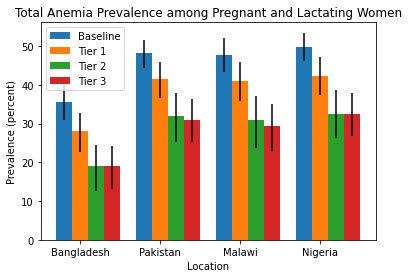

In [77]:
plot_anemia_burden(anemia_rates_overall, 'prevalence', 'anemic', 1)

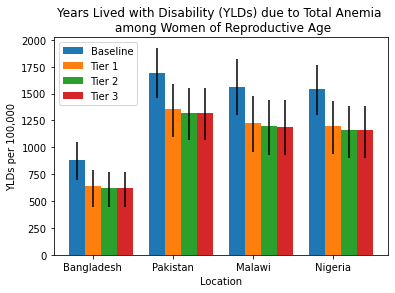

In [76]:
plot_anemia_burden(anemia_rates_overall, 'ylds', 'anemic', 0)

In [81]:
# plot anemia prevalence

def plot_maternal_disorders_burden(data_set, measure):
    data = pd.DataFrame(data_set.stack()).reset_index().rename(columns={'level_5':'draw',0:'value'})
    data = data.loc[data.measure == measure]
    data = data.groupby(['location_id','intervention']).describe(percentiles=[0.025,0.975]).reset_index()

    baseline = data.loc[data.intervention == 'baseline']
    baseline_upper = baseline['value','97.5%'] - baseline['value','mean']
    baseline_lower = baseline['value','mean'] - baseline['value','2.5%']

    salt = data.loc[data.intervention == 'salt']
    salt_upper = salt['value','97.5%'] - salt['value','mean']
    salt_lower = salt['value','mean'] - salt['value','2.5%']

    anc = data.loc[data.intervention == 'anc']
    anc_upper = anc['value','97.5%'] - anc['value','mean']
    anc_lower = anc['value','mean'] - anc['value','2.5%']

    iv = data.loc[data.intervention == 'iv_with_salt']
    iv_upper = iv['value','97.5%'] - iv['value','mean']
    iv_lower = iv['value','mean'] - iv['value','2.5%']

    bw=0.2

    # bar positions
    a = np.arange(len(baseline)) 
    b = [x + bw for x in a]
    c = [x + bw for x in b]
    d = [x + bw for x in c]

    plt.bar(a, baseline['value','mean'].values, yerr=[baseline_upper.values, baseline_lower.values], width=bw)
    plt.bar(b, salt['value','mean'].values, yerr=[salt_upper.values, salt_lower.values], width=bw)
    plt.bar(c, anc['value','mean'].values, yerr=[anc_upper.values, anc_lower.values], width=bw)
    plt.bar(d, iv['value','mean'].values, yerr=[iv_upper.values, iv_lower.values], width=bw)

    plt.legend(['Baseline','Tier 1','Tier 2','Tier 3'])

    if measure == 'ylds':
        title = 'Years Lived with Disability (YLDs) due to Maternal Disorders per 100,000'
        ytitle = 'YLDs per 100,000'
    else:
        title = 'Years of Life Lost (YLLs) due to Maternal Disorders per 100,000'
        ytitle = 'YLLs per 100,000'
   
    plt.xticks([r + bw for r in range(len(baseline))], location_names)
    plt.title(title)
    plt.xlabel('Location')
    plt.ylabel(ytitle)

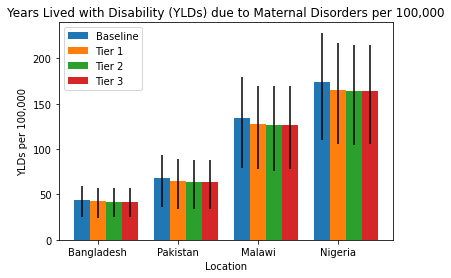

In [82]:
plot_maternal_disorders_burden(burden_rates_overall, 'ylds')

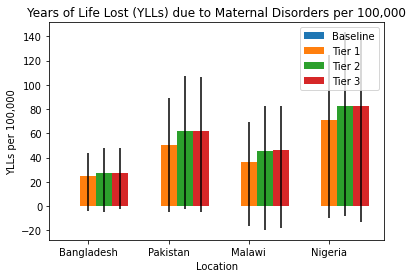

In [83]:
plot_maternal_disorders_burden(burden_averted_rate, 'ylls')

In [84]:
(burden_averted_rate.min()).min()
# this is weird!!!!
# need to look into this

-14.336897851785125

In [85]:
(double_fortified_salt_risk_difference.min()).min()

0.7866300637406676